In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, train_test_split
from sklearn.linear_model import Perceptron, LogisticRegression

import earthpy.plot as ep

# personal scripts
from plots import eval_hist, single_hist

In [2]:
train_data = np.load('data/train.npz')
train_data.files

['bands', 'lulc']

# Data Exploration

## lulc data
The lulc data contains the labels for the patches in bands.

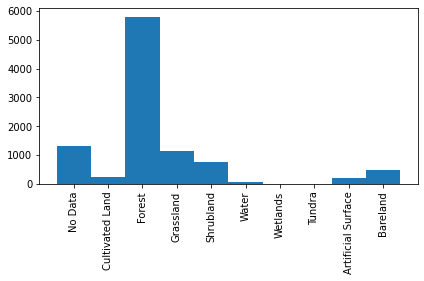

In [3]:
a = train_data['lulc']
single_hist(a)

# Data preparation

In [4]:
bands = train_data['bands']
y_true = train_data['lulc']

In [5]:
X = bands[:, :, 17, 17, :].reshape((10000, 12, 6))
X.shape

(10000, 12, 6)

In [6]:
X_train, X_val, y_train, y_val = train_test_split(X, y_true, test_size=0.3, random_state=42)

In [7]:
nsamples, f_one, f_two = X_train.shape
X_train_d2 = X_train.reshape((nsamples, f_one * f_two))

nsamples, f_one, f_two = X_val.shape
X_val_d2 = X_val.reshape((nsamples, f_one * f_two))

# 1. Decision tree classifier

In [8]:
clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X_train_d2, y_train)
y_pred = clf.predict(X_val_d2)

Tree depth: 27.00
Number of leafs: 1104.00
Accuracy on training set: 1.00
Accuracy on validation set: 0.65


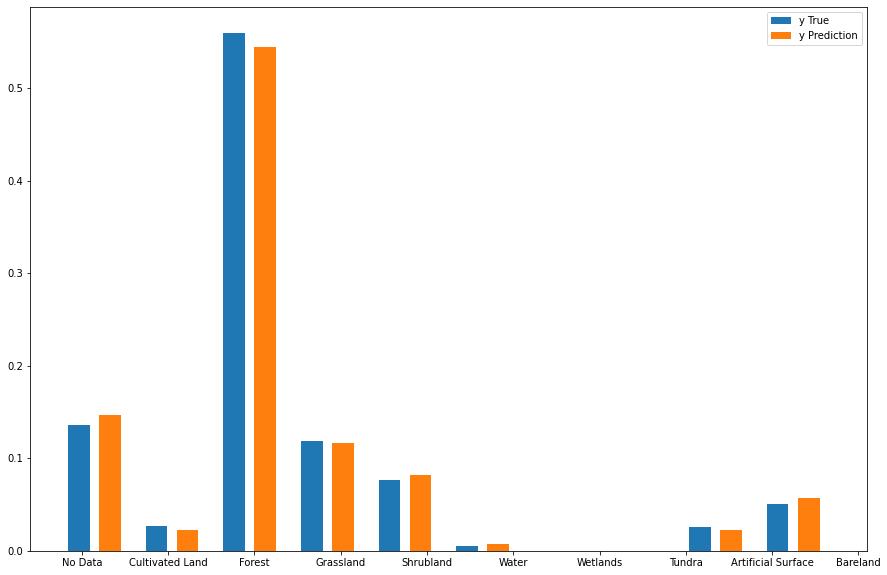

In [9]:
print("Tree depth: {:.2f}".format(clf.get_depth()))
print("Number of leafs: {:.2f}".format(clf.get_n_leaves()))
print("Accuracy on training set: {:.2f}".format(clf.score(X_train_d2, y_train)))
print("Accuracy on validation set: {:.2f}".format(clf.score(X_val_d2, y_val)))
eval_hist(y_val, y_pred)


# 2. Perceptron
Perveptron algorithm with grid search.

From: [machinelearningmastery](https://machinelearningmastery.com/perceptron-algorithm-for-classification-in-python/)

In [10]:
# define model
model = Perceptron()

In [11]:
# define model evaluation method
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)

In [12]:
# define grid
grid = dict()
grid['eta0'] = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0, 10000.0, 1000000.0]

# define search
search = GridSearchCV(model, grid, scoring='accuracy', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_train_d2, y_train)

In [13]:
# summarize
print('Mean Accuracy: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

# summarize all
means = results.cv_results_['mean_test_score']
params = results.cv_results_['params']
for mean, param in zip(means, params):
    print(">%.3f with: %r" % (mean, param))
    

Mean Accuracy: 0.610
Config: {'eta0': 0.0001}
>0.610 with: {'eta0': 0.0001}
>0.610 with: {'eta0': 0.001}
>0.604 with: {'eta0': 0.01}
>0.603 with: {'eta0': 0.1}
>0.607 with: {'eta0': 1.0}
>0.609 with: {'eta0': 10.0}
>0.608 with: {'eta0': 100.0}
>0.609 with: {'eta0': 1000.0}
>0.609 with: {'eta0': 10000.0}
>0.609 with: {'eta0': 1000000.0}


Accuracy on training set: 0.58
Accuracy on validation set: 0.57


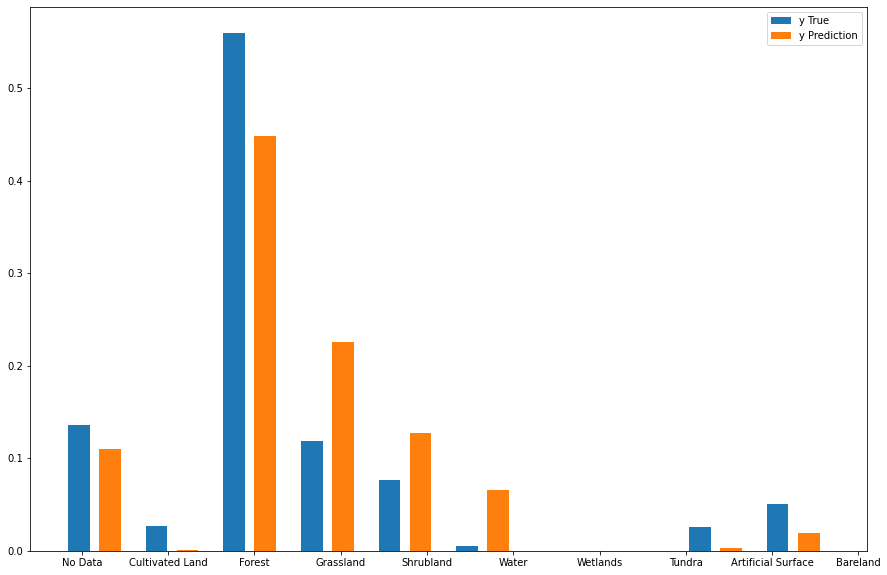

In [14]:
y_pred = search.predict(X_val_d2)

print("Accuracy on training set: {:.2f}".format(search.score(X_train_d2, y_train)))
print("Accuracy on validation set: {:.2f}".format(search.score(X_val_d2, y_val)))

eval_hist(y_val, y_pred)

# 3. Logistic regression

In [15]:
clf = LogisticRegression(random_state=42).fit(X_train_d2, y_train)
y_pred = clf.predict(X_val_d2)

/Users/tillhoffmann/Projects/uni/DA2/satellite-segmentation/venv/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Accuracy on training set: 0.70
Accuracy on validation set: 0.68


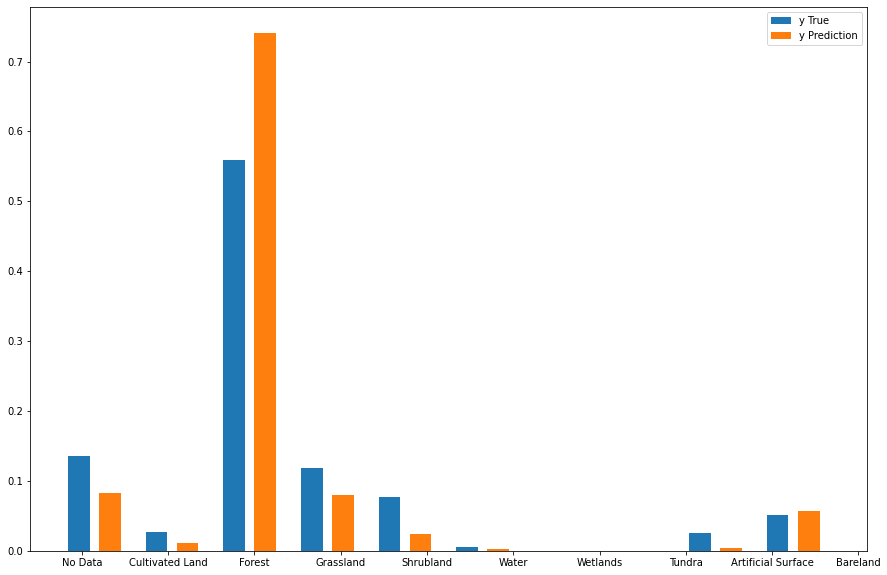

In [16]:
print("Accuracy on training set: {:.2f}".format(clf.score(X_train_d2, y_train)))
print("Accuracy on validation set: {:.2f}".format(clf.score(X_val_d2, y_val)))
eval_hist(y_val, y_pred)

# Plot data with labels

In [17]:
public_test_data = np.load('data/public_test.npz')

# extract bands from train set:
public_bands = public_test_data['bands']

public_bands.shape

(12, 500, 500, 6)

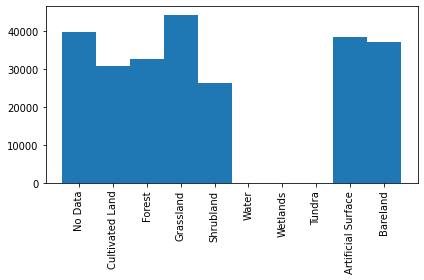

In [18]:
clf = DecisionTreeClassifier(criterion='gini')
clf.fit(X_train_d2, y_train)


months, f_one, f_two, color = public_bands.shape
X_public_d2 = public_bands.reshape((f_one * f_two, color * months))

y_pred = clf.predict(X_public_d2)
single_hist(y_pred)

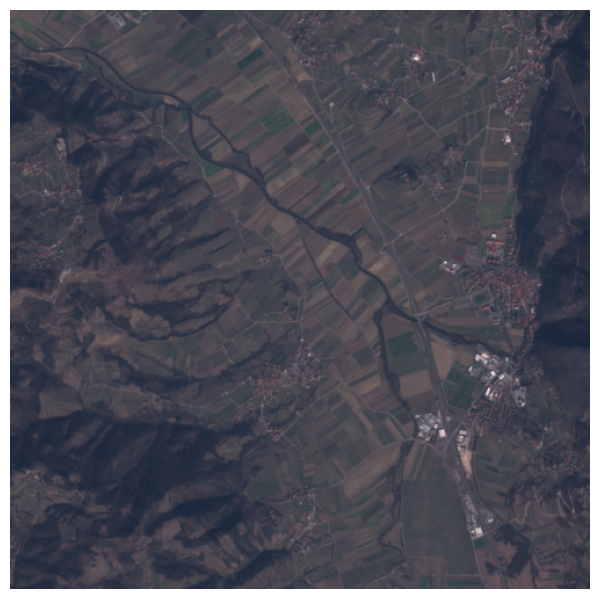

In [19]:
# Plot image:
plt.figure(figsize=(8, 8), dpi=96)
### Load September
band = public_bands[2,:,:,:3]
### Flip from BGR to RGB
band = np.flip(band, -1)
### Change Bridness
band += .3
### Change Contrast
c_fact = 2.5
band = 0.5 + c_fact * (band - 0.5)
### Clip high values
band = band.clip(0,1)

plt.axis('off')
plt.imshow(band, cmap='gray')

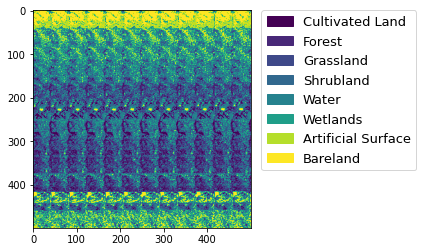

In [20]:
im_arr = y_pred.reshape(500, 500)
bins = np.arange(10)
im_arr_bin = np.digitize(im_arr, bins)
cat_names = ['Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Artificial Surface', 'Bareland']
f, ax = plt.subplots()
im = ax.imshow(im_arr_bin, cmap="gnuplot")
im_ax = ax.imshow(im_arr_bin)
leg_neg = ep.draw_legend(im_ax = im_ax, titles = cat_names)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


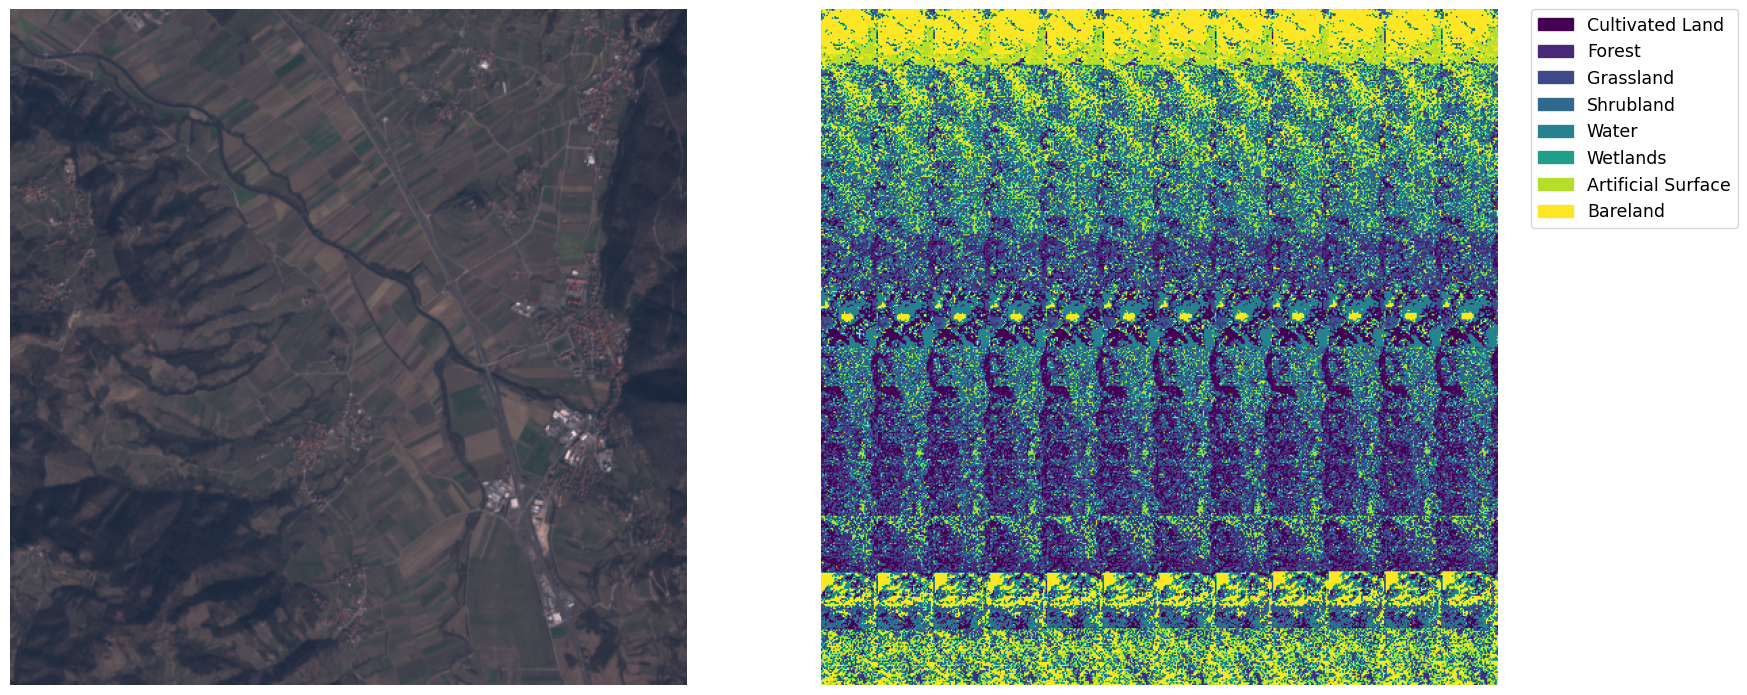

In [26]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 20), dpi=96)

# Plot correct image:
### Load September
band_sep = public_bands[2,:,:,:3]
### Flip from BGR to RGB
band_flip = np.flip(band_sep, -1)
### Change Bridness
# band_bright = band_flip + .3
### Change Contrast
c_fact = 2.5
band = 0.5 + c_fact * (band_flip - 0.5)


ax1.axis('off')
ax1.imshow(band, cmap='gray')


# Plot prediction
im_arr = y_pred.reshape(500, 500)
bins = np.arange(10)
im_arr_bin = np.digitize(im_arr, bins)
cat_names = ['Cultivated Land', 'Forest', 'Grassland', 'Shrubland', 'Water', 'Wetlands', 'Artificial Surface', 'Bareland']

im = ax2.imshow(im_arr_bin, cmap="gnuplot")
im_ax2 = ax2.imshow(im_arr_bin)
leg_neg = ep.draw_legend(im_ax = im_ax2, titles = cat_names)
ax2.axis('off')
plt.show()